In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import torch
import terra
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns

In [2]:
from meerkat.contrib.mimic import build_mimic_dp
import os
import meerkat as mk
from domino.data.mimic import split_dp, build_dp
from domino.vision import score
from functools import partial

In [13]:
target = "pleural_effusion_uzeros"
dp = terra.out(4454).load()
dp["ethnicity_white"] = dp["ethnicity"] == "WHITE"

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

train_mask = np.random.random(len(dp)) > 0.5

targets = [
    target, 
    "ethnicity_black", 
    "ethnicity_asian", 
    "ethnicity_hisp", 
    "ethnicity_white",
    "patient_orientation_rf", 
    "support_devices_uzeros",
    "gender_male"
]
results = []
for target in tqdm(targets):
    for layer in [col for col in dp.columns if col.startswith("act")]:
        train_dp = dp.lz[train_mask]
        lr = LogisticRegression()
        lr.fit(
            X=dp.lz[train_mask][layer].numpy(), 
            y=dp.lz[train_mask][target].values
        )
        preds = lr.predict_proba(
            X=dp.lz[~train_mask][layer].numpy(), 
        )[:, -1]
        score = roc_auc_score(
            dp.lz[~train_mask][target].values,
            preds, 
        )
        results.append(
            {
                "target": target,
                "layer": layer[4:],
                "auroc": score
            }
        )
df = pd.DataFrame(results)

In [56]:
dfs = []
for model_target, run_id in [
    ("pleural_effusion", 4460),
    ("edema", 4462),
    ("support_devices", 4465),
    ("imagenet", 4468)
]:
    df = terra.out(run_id).load()
    df["model_target"] = model_target
    df.target[df.target == model_target+ "_uzeros"] = "model_target"
    dfs.append(df)
df = pd.concat(dfs)
df

,target,layer,auroc,model_target
0,model_target,4.0,0.880935,pleural_effusion
1,model_target,4.1,0.881272,pleural_effusion
2,model_target,4.2,0.880302,pleural_effusion
3,model_target,3.0,0.806966,pleural_effusion
4,model_target,3.1,0.815985,pleural_effusion
...,...,...,...,...
107,gender_male,2.2,0.851899,imagenet
108,gender_male,2.3,0.860586,imagenet
109,gender_male,1.0,0.705383,imagenet
110,gender_male,1.1,0.733982,imagenet


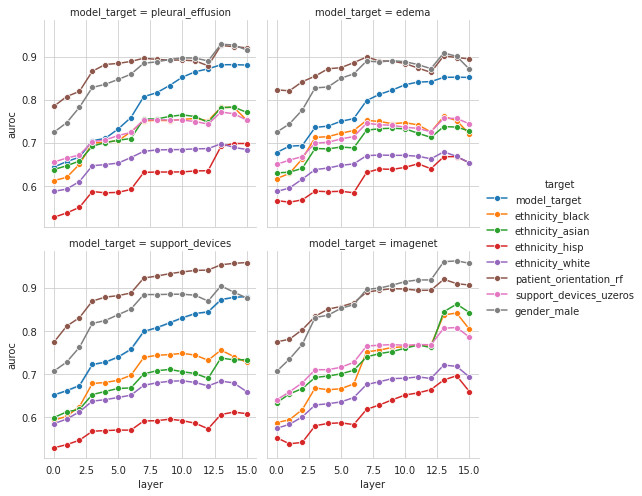

In [95]:
dfs = []
for model_target, run_id in [
    ("pleural_effusion", 4460),
    ("edema", 4462),
    ("support_devices", 4465),
    ("imagenet", 4468)
]:
    df = terra.out(run_id).load()
    df["model_target"] = model_target
    df.target[df.target == model_target+ "_uzeros"] = "model_target"
    dfs.append(df)
df = pd.concat(dfs)
df

layers = df.layer.unique()
order = layers.argsort()
ranks = order.argsort()
df["layer"] = df.layer.map(dict(zip(layers, ranks)))

sns.set_style("whitegrid")
g = sns.FacetGrid(
    data=df,
    col="model_target",
    col_wrap=2,
    hue="target",
    palette=sns.color_palette("tab10"),
    height=3.5
)

g.map(
    sns.lineplot,
    "layer", 
    "auroc",
    marker="o"
)
g.add_legend()
sns.despine()

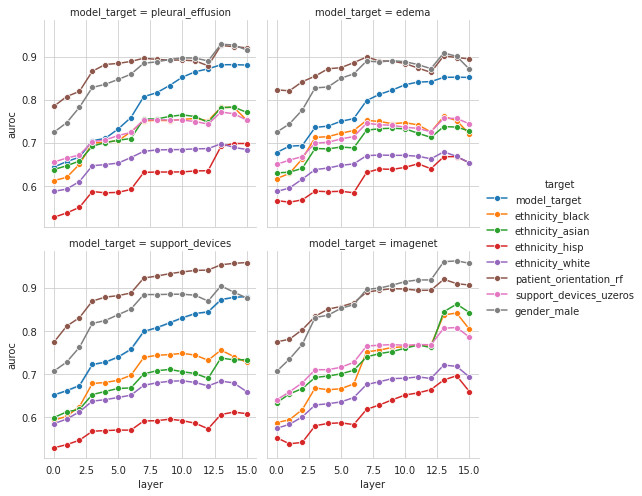

In [94]:
sns.set_style("whitegrid")
g = sns.FacetGrid(
    data=df,
    col="model_target",
    col_wrap=2,
    hue="target",
    palette=sns.color_palette("tab10"),
    height=3.5
)

g.map(
    sns.lineplot,
    "layer", 
    "auroc",
    marker="o"
)
g.add_legend()
sns.despine()

In [ ]:
sns.set_style("whitegrid")
sns.factorplot(
    data=df,
    col="model_target",
    y="layer", 
    x="auroc",
    hue="target",
    palette=sns.color_palette("tab10"),
    height=6
)
sns.despine()

In [123]:
dp["ethnicity"].unique()

array(['BLACK/AFRICAN AMERICAN', 'WHITE', None, 'OTHER', 'UNKNOWN',
       'HISPANIC/LATINO', 'ASIAN', 'AMERICAN INDIAN/ALASKA NATIVE',
       'UNABLE TO OBTAIN'], dtype=object)

In [24]:
inp = terra.inp(4454)
out = inp["dp"].load()

In [29]:
(out["split"] == "valid").sum()

2124

In [97]:
from torch.nn import BCELoss

In [103]:
loss = BCELoss(weight=torch.ones(5))

In [108]:
out = torch.load("/home/sabri/terra/slice/tasks/__main__/train_model/_runs/4485/artifacts/9cf26558bed542d59210c48c18132975")


In [111]:
out["config"]["targets"] = [
            f"{tgt}_uzeros"
            for tgt in [
                "atelectasis",
                "cardiomegaly",
                "consolidation",
                "edema",
                "enlarged_cardiomediastinum",
                "fracture",
                "lung_opacity",
                "pleural_effusion",
                "pleural_other",
                "pneumonia",
                "pneumothorax",
                "support_devices",
                "lung_lesion",
                "no_finding"
            ]
        ]

In [112]:
torch.save(out, "/home/sabri/terra/slice/tasks/__main__/train_model/_runs/4485/artifacts/9cf26558bed542d59210c48c18132975")

In [3]:
model = terra.get_artifacts(4490, "best_chkpt")["model"].load()

In [4]:
dp = terra.inp(4490)["dp"].load()

In [121]:
from domino.vision import score
score_dp = score(
    model=model,
    dp=dp.lz[dp["split"] == "valid_test"],
    input_column="input_512",
    batch_size=64,
)

In [123]:
from sklearn.metrics import roc_auc_score

{
    target: roc_auc_score(score_dp[target], score_dp["output"].data[:, idx])
    for idx, target in enumerate(model.targets)
}

{'atelectasis_uzeros': 0.8063723398807489,
 'cardiomegaly_uzeros': 0.8098860173111074,
 'consolidation_uzeros': 0.8075509881874298,
 'edema_uzeros': 0.8927357543008524,
 'enlarged_cardiomediastinum_uzeros': 0.7269744388050433,
 'fracture_uzeros': 0.6821313380134197,
 'lung_opacity_uzeros': 0.7609155041040003,
 'pleural_effusion_uzeros': 0.9086251931021927,
 'pleural_other_uzeros': 0.8235755501131767,
 'pneumonia_uzeros': 0.734250609090275,
 'pneumothorax_uzeros': 0.8723238828587042,
 'support_devices_uzeros': 0.9172779991539173,
 'lung_lesion_uzeros': 0.7464454651551815,
 'no_finding_uzeros': 0.8586176660806775}

In [5]:
model.to(0)
model(dp["input_512"][:16].data.to(0))

torch.Size([16, 256, 128, 128])
torch.Size([16, 256, 128, 128])
torch.Size([16, 256, 128, 128])
torch.Size([16, 512, 64, 64])
torch.Size([16, 512, 64, 64])
torch.Size([16, 512, 64, 64])
torch.Size([16, 512, 64, 64])
torch.Size([16, 1024, 32, 32])
torch.Size([16, 1024, 32, 32])
torch.Size([16, 1024, 32, 32])
torch.Size([16, 1024, 32, 32])
torch.Size([16, 1024, 32, 32])
torch.Size([16, 1024, 32, 32])
torch.Size([16, 2048, 16, 16])
torch.Size([16, 2048, 16, 16])
torch.Size([16, 2048, 16, 16])


tensor([[-2.8333, -3.1269, -3.4815, -1.0562, -4.4127, -4.1742, -0.6796, -2.4630,
         -4.8720, -2.6500, -4.4281, -2.5193, -3.6020, -1.5540],
        [-1.7391, -1.8282, -3.8827, -1.0057, -4.3600, -4.4088, -1.0068, -2.8041,
         -5.7616, -2.3762, -5.8512, -3.5309, -4.6703, -1.3417],
        [-1.8696, -1.3778, -3.8771, -0.8320, -4.4688, -4.9602, -1.0208, -2.7146,
         -6.0195, -2.3621, -5.8632, -2.6811, -4.9810, -1.6078],
        [-1.1184, -2.6508, -3.1663, -5.3738, -3.3770, -3.1379, -1.1499, -1.5804,
         -4.2685, -2.5556, -2.9883, -2.0126, -3.0782, -0.5526],
        [-2.5452, -1.4023, -3.9203, -4.6607, -3.6755, -3.2760, -1.7458, -3.2607,
         -4.2383, -2.8054, -3.3851, -2.1153, -3.2321, -0.4555],
        [-3.2179, -2.7020, -4.6261, -4.3399, -5.1333, -4.3365, -2.3323, -4.3888,
         -6.1203, -3.3311, -6.3089, -4.4349, -4.6028,  0.7783],
        [-2.1804, -3.6653, -4.3711, -5.5394, -4.1059, -3.4358, -1.3525, -5.5009,
         -4.7835, -2.3866, -5.1442, -3.2461, -2.7